In [21]:
from collections import OrderedDict

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensorflow_probability as tfp

from gpflow import default_float
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import random
from simenvs import make

from modeopt.mode_opt import ModeOpt
from modeopt.plotting import ModeOptContourPlotter

%matplotlib inline

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
# meaning_of_life = 1
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

## Load ModeOpt from checkpoint

In [22]:
ckpt_dir = "./experiments/mvn-full-cov/explorative-prob-0.8/2022-04-20-17-47/ckpts"
mode_optimiser = ModeOpt.load(ckpt_dir)

setting desired mode to 1
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                                 │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════════════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 2.2916326708249595                                    │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────

2022-04-26 17:52:49.744666: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-26 17:52:49.744702: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-26 17:52:49.744860: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [23]:
mode_optimiser.create_checkpoint_manager()
checkpoint = tf.train.Checkpoint(mode_optimiser)
full_dataset = (mode_optimiser.dataset[0].copy(), mode_optimiser.dataset[1].copy())

## Configure plotter

In [24]:
def create_test_inputs(x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 1600, factor: float = 1.2):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy

test_inputs, xx, yy = create_test_inputs()
plotter = ModeOptContourPlotter(mode_optimiser, test_inputs=test_inputs, static=False, explorative=True)

In [25]:
def plot_gating_function_entropy(fig, ax):
    h_means, h_vars = mode_optimiser.dynamics.mosvgpe.gating_network.predict_h(test_inputs)
    h_dist = tfd.MultivariateNormalDiag(h_means[:, mode_optimiser.desired_mode:], h_vars[:, mode_optimiser.desired_mode:]**2)
    gating_entropy = h_dist.entropy()
    contf = ax.tricontourf(test_inputs[:, 0], 
                           test_inputs[:, 1], 
                           gating_entropy,
#                            levels=10,
                           levels=np.linspace(0, 8.0, 13),
                           cmap=plotter.mosvgpe_plotter.cmap)
    return contf

In [26]:
def plot_bernoulli_entropy(fig, ax):
    h_means, h_vars = mode_optimiser.dynamics.mosvgpe.gating_network.predict_h(test_inputs)
    mode_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs_given_h(h_means, h_vars)
    gating_entropy = tfd.Bernoulli(mode_probs[:, mode_optimiser.desired_mode]).entropy()
    contf = ax.tricontourf(test_inputs[:, 0], 
                           test_inputs[:, 1], 
                           gating_entropy,
#                            levels=10,
                           levels=np.linspace(0.59, 0.7, 13),
                           cmap=plotter.mosvgpe_plotter.cmap)
    return contf

In [27]:
def binary_entropy(probs):
    return -probs * tf.math.log(probs) - (1 - probs) * tf.math.log(1 - probs)

def entropy_approx(h_means, h_vars, mode_probs):
    C = tf.constant(np.sqrt(math.pi * np.log(2.0) / 2.0), dtype=default_float())
    param_entropy = C * tf.exp(-(h_means ** 2) / (2 * (h_vars ** 2 + C ** 2)))
    param_entropy = param_entropy / (tf.sqrt(h_vars ** 2 + C ** 2))
    model_entropy = binary_entropy(mode_probs)
    return model_entropy - param_entropy

def plot_bald_objective(fig, ax):
    h_means, h_vars = mode_optimiser.dynamics.mosvgpe.gating_network.predict_h(test_inputs)
    mode_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs_given_h(h_means, h_vars)
    bald_objective = entropy_approx(h_means[:, mode_optimiser.desired_mode], 
                                    h_vars[:, mode_optimiser.desired_mode], 
                                    mode_probs[:, mode_optimiser.desired_mode])
    contf = ax.tricontourf(test_inputs[:, 0], 
                           test_inputs[:, 1], 
                           bald_objective,
                           levels=np.linspace(0, 0.65, 13),
                           cmap=plotter.mosvgpe_plotter.cmap)
    return contf

In [28]:
def plot_entropy_objectives_single_iteration(fig, axs, i, row):
    checkpoint.restore(os.path.join(ckpt_dir, "ckpt-"+str(i+1)))
    mode_optimiser.dataset = (full_dataset[0][:int(mode_optimiser.dataset_idx.numpy()), :], 
                              full_dataset[0][:int(mode_optimiser.dataset_idx.numpy()), :])
    checkpoint.restore(os.path.join(ckpt_dir, "ckpt-"+str(i+2)))
    
    contfs = []
    contfs.append(plot_gating_function_entropy(fig, axs[0]))
    contfs.append(plot_bernoulli_entropy(fig, axs[1]))
    contfs.append(plot_bald_objective(fig, axs[2]))
        
    for ax in axs.flat:
        plotter.plot_mode_satisfaction_probability_given_ax(ax)
        ax.scatter(mode_optimiser.dataset[0][:, 0], mode_optimiser.dataset[0][:, 1], color='b', marker='x', alpha=0.05, label="Observations")
    
    if i == 0:
        mode_optimiser.dataset = (full_dataset[0][:123, :], full_dataset[0][:123, :])
    elif row == 0:
        mode_optimiser.dataset = (full_dataset[0][:int(mode_optimiser.dataset_idx.numpy()), :], 
                                  full_dataset[0][:int(mode_optimiser.dataset_idx.numpy()), :])
    checkpoint.restore(os.path.join(ckpt_dir, "ckpt-"+str(i+2)))
    axs[0].set_ylabel(f"$y \quad (i={i})$")
    return contfs


def plot_entropy_objectives(iterations, save_filename=None):
    fig = plt.figure(figsize=(plotter.mosvgpe_plotter.figsize[0] * 1.2, plotter.mosvgpe_plotter.figsize[1]*2.5))
    gs = fig.add_gridspec(4, 3, wspace=0.2, hspace=0.0)
#     gs = fig.add_gridspec(4, 3)
    axs = gs.subplots(sharex=True, sharey='row')

    row = 0
    gating_function_contfs, bernoulli_contfs, bald_contfs = [], [], []
    for i in iterations:
        contfs = plot_entropy_objectives_single_iteration(fig, axs[row, :], i, row=row)
        gating_function_contfs.append(contfs[0]) 
        bernoulli_contfs.append(contfs[1])
        bald_contfs.append(contfs[2])
        row += 1
    
    for ax in axs[-1, :].flat:
        ax.set_xlabel("$x$")

    def add_cbar(ax, contf, label):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cbar = plt.colorbar(contf, use_gridspec=True, cax=cax, orientation="horizontal", format='%.2f')
        cbar.set_label(label)
        cax.xaxis.set_ticks_position("top")
        cax.xaxis.set_label_position("top")

        
    add_cbar(axs[0, 0], gating_function_contfs[-1], "$H[h(\mathbf{x}) \mid \mathbf{x}, \mathcal{D}_{0:i}]$")
    add_cbar(axs[0, 1], bernoulli_contfs[-1], "$H[\\alpha \mid \mathbf{x}, \mathcal{D}_{0:i}]$")
    add_cbar(axs[0, 2], bald_contfs[-1], "$H[\\alpha \mid \mathbf{x}, \mathcal{D}_{0:i}] - \mathbb{E}_{p(h(\mathbf{x}) \mid \mathbf{x}, \mathcal{D}_{0:i})} [H[\\alpha \mid h(\mathbf{x})]]$")

    plotter.plot_env_no_obs_start_end_given_fig(fig)
    handles, labels = axs[-1, 1].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.tight_layout()
    fig.legend(
        by_label.values(),
        by_label.keys(),
        bbox_to_anchor=(0.5, 0.03),
        loc="lower center",
        bbox_transform=fig.transFigure,
        ncol=len(by_label),
    )
    if save_filename:
        plt.savefig(save_filename, transparent=True)

/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_11372/4221204731.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


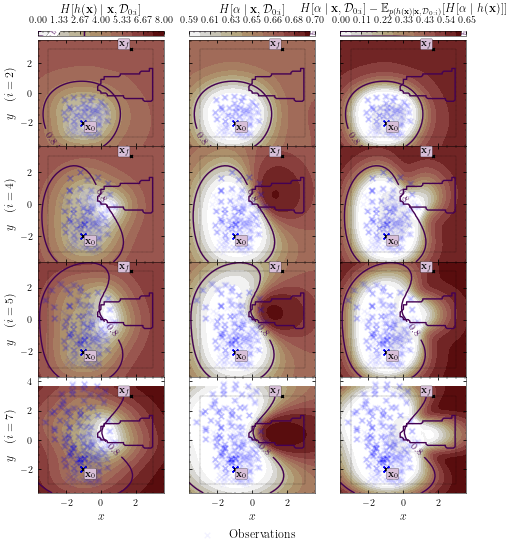

In [29]:
iterations = [2, 4, 5, 7]
save_filename = "./reports/figures/entropy_comparison_iterations_2_to_7.pdf"
plot_entropy_objectives(iterations, save_filename=save_filename)